In [5]:
file_No = 32
fold = 0

# Importing dependencies

In [1]:
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import lightgbm as lgb
import random
from tqdm.notebook import tqdm
import math
from functools import partial
import h5py
from datetime import datetime
import os
import time
import gc
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA


# Config

In [6]:
class config:
    epochs = 100
    batch_size = 16
    test_batch_size = 16
    learning_rate = 1e-3
    fMRI_mask_path = '../input/trends-assessment-prediction/fMRI_mask.nii'
    root_train_path = '../input/trends-assessment-prediction/fMRI_train'
    root_test_path = '../input/trends-assessment-prediction/fMRI_test'
    num_folds = 5
    seed = 2020
    verbose = True
    verbose_step = 1
    num_workers = 4
    test_num_workers = 4
    target = ["age", "domain1_var1", "domain1_var2", "domain2_var1", "domain2_var2"]
    weight = [0.3, 0.175, 0.175, 0.175, 0.175]
    # cross validationをするときはここでfoldを変更する
    fold = fold

In [7]:
print("fold",config.fold, "file_No", file_No)

fold 0 file_No 32


# Loading data

In [11]:
train_df = pd.read_csv("../input/trends-assessment-prediction/train_scores.csv")
drop_cols = ["age", "domain1_var1", "domain1_var2", "domain2_var1", "domain2_var2"]
train_df.drop(drop_cols, axis=1, inplace=True)
train_df["is_train"] = True

fnc = pd.read_csv("../input/trends-assessment-prediction/fnc.csv")
fnc.fillna(fnc.mean(), inplace=True)
# PCAのためのコード(変更点はここだけ)
pca = PCA()
tmp_pca = pca.fit_transform(fnc.iloc[:, 1:])
fnc.iloc[:, 1:] = tmp_pca
fnc = fnc.merge(train_df, on="Id", how="left")
test_fnc = fnc[fnc["is_train"] != True].copy().reset_index(drop=True)
fnc = fnc[fnc["is_train"] == True].copy().reset_index(drop=True)

loading = pd.read_csv("../input/trends-assessment-prediction/loading.csv")
loading.fillna(loading.mean(), inplace=True)
# ICAのためのコード(変更点はここだけ)
ica = FastICA(n_components=26, random_state=config.seed)#26個の基底（コンポネント）を作る
tmp_ica = ica.fit_transform(loading.iloc[:, 1:])
loading.iloc[:, 1:] = tmp_ica
loading = loading.merge(train_df, on="Id", how="left")
test_loading = loading[loading["is_train"] != True].copy().reset_index(drop=True)
loading = loading[loading["is_train"] == True].copy().reset_index(drop=True)


In [12]:
# devide test data site2 and unknow
site2_id = pd.read_csv("../input/trends-assessment-prediction/reveal_ID_site2.csv")
site2_id['is_site2'] = 1
loading["is_site2"] = 0
fnc["is_site2"] = 0
test_loading = pd.merge(test_loading, site2_id, how="left")
test_loading.loc[test_loading["is_site2"] != 1, ["is_site2"]] = "unknow"
test_fnc = pd.merge(test_fnc, site2_id, how="left")
test_fnc.loc[test_fnc["is_site2"] != 1, ["is_site2"]] = "unknow"

adversal_loading_df = pd.concat([loading, test_loading[test_loading["is_site2"] == 1]], axis=0).reset_index(drop=True).drop("is_train", axis=1)
adversal_fnc_df = pd.concat([fnc, test_fnc[test_fnc["is_site2"] == 1]], axis=0).reset_index(drop=True).drop("is_train", axis=1)

In [13]:
test_loading_uk = test_loading[test_loading["is_site2"]=="unknow"]
test_fnc_uk = test_fnc[test_fnc["is_site2"]=="unknow"]
test_uk = pd.concat([test_loading_uk.iloc[:, :-2], test_fnc_uk.iloc[:, 1:]], axis=1)
test_uk

,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,...,CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4),is_train,is_site2
0,10003,0.001773,-0.022619,0.011245,0.006263,0.004506,0.001837,-0.002990,-0.007514,0.007815,...,-0.008089,0.007553,-0.001537,-0.000295,0.027542,0.001851,-0.006289,0.035512,NaN,unknow
1,10006,-0.006634,0.015736,0.008110,-0.008867,-0.004373,-0.005614,-0.011459,0.013899,0.001005,...,-0.022968,0.016576,0.011121,0.004894,-0.001222,0.000629,-0.001791,-0.010822,NaN,unknow
2,10010,-0.007115,-0.013148,0.002990,0.004683,0.006263,-0.009233,-0.006109,0.009008,0.002716,...,0.003435,-0.017209,-0.006396,-0.016368,-0.008776,0.007905,0.009069,0.012164,NaN,unknow
3,10011,0.021160,-0.000159,-0.014224,-0.005080,0.006027,-0.002728,0.006584,0.002491,0.003179,...,0.032691,0.014722,-0.024111,-0.009436,0.010620,-0.004647,0.015439,0.002102,NaN,unknow
5,10013,-0.000522,0.010303,-0.007390,0.004734,0.009076,0.008248,0.017517,0.006203,-0.007627,...,0.008781,0.000184,-0.018234,0.010558,-0.006754,-0.013567,-0.000608,0.015908,NaN,unknow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5871,21743,0.017296,0.017242,0.008566,-0.010857,-0.032505,0.022021,-0.004424,-0.014099,0.003770,...,-0.022844,0.025651,0.016051,0.017911,0.005520,-0.011658,-0.003599,-0.018240,NaN,unknow
5872,21745,-0.003897,0.006929,-0.003079,0.008001,0.000435,-0.013135,0.006371,-0.007709,0.010582,...,0.009428,-0.009739,-0.025083,-0.000636,-0.003803,-0.019569,0.001923,-0.008353,NaN,unknow
5873,21748,-0.002846,-0.012671,0.001238,-0.007412,-0.003740,-0.005927,0.001805,0.007067,0.005712,...,-0.004427,-0.010262,-0.008161,-0.001392,-0.005379,0.007551,0.001166,0.012465,NaN,unknow
5875,21751,0.023335,0.016093,-0.014900,-0.009015,0.002904,-0.005859,0.002416,-0.008353,-0.005259,...,-0.014024,-0.007903,-0.006733,-0.001717,-0.010655,-0.010263,0.001108,-0.001550,NaN,unknow


In [14]:
adversal_loading_df['kfold'] = -1
adversal_fnc_df['kfold'] = -1

kf = StratifiedKFold(n_splits=config.num_folds, shuffle=True, random_state=config.seed)
for fold, (trn_, val_) in enumerate(kf.split(adversal_loading_df[adversal_loading_df.columns[1:-1]], adversal_loading_df["is_site2"].astype(int))):
    adversal_loading_df.loc[val_, 'kfold'] = fold
    adversal_fnc_df.loc[val_, 'kfold'] = fold

In [15]:
adversal_target_df = adversal_loading_df[["Id", "is_site2", "kfold"]]
adversal_target_df.loc[:, 'path'] = -1
id_names = adversal_target_df.loc[adversal_target_df["is_site2"]==0, ["Id"]].values.astype(str)
adversal_target_df.loc[adversal_target_df['is_site2']==0, ['path']] = [f"{config.root_train_path}/{id_name}.mat" for id_name in list(id_names.squeeze())]
id_names = adversal_target_df.loc[adversal_target_df["is_site2"]==1, ["Id"]].values.astype(str)
adversal_target_df.loc[adversal_target_df['is_site2']==1, ['path']] = [f"{config.root_test_path}/{id_name}.mat" for id_name in list(id_names.squeeze())]
adversal_target_df.nunique()

Id          6387
is_site2       2
kfold          5
path        6387
dtype: int64

In [16]:
a = pd.concat([adversal_loading_df.iloc[:, :-2], adversal_fnc_df.iloc[:, 1:]], axis=1)
a

,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,...,CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4),is_site2,kfold
0,10001,-0.000094,-0.000321,0.008688,-0.020261,-0.001522,0.014406,-0.007024,-0.003085,0.003999,...,0.014345,-0.009595,0.002807,-0.003329,0.000004,0.005466,0.016028,0.002611,0,1
1,10002,-0.009415,-0.005627,0.006846,-0.016897,0.010808,0.006448,0.000750,-0.001672,-0.000120,...,-0.018003,0.007037,0.012904,0.016405,0.014921,-0.011890,0.008003,-0.007597,0,1
2,10004,-0.013708,-0.001184,0.014903,0.004514,-0.014002,-0.008291,0.002048,0.012402,-0.000553,...,0.010765,0.016007,-0.008539,-0.029088,0.010970,-0.024510,0.015232,0.003195,0,4
3,10005,-0.010586,-0.002656,0.012353,0.000904,-0.003883,0.005902,-0.008123,0.003880,-0.015683,...,0.002189,-0.014440,0.021097,-0.003547,-0.023715,-0.002997,-0.009689,0.004043,0,4
4,10007,0.002987,-0.000605,0.001447,-0.005544,0.003310,-0.000938,-0.001776,-0.006352,-0.004519,...,0.017491,0.023528,0.002276,-0.019337,-0.010830,-0.018382,-0.002654,-0.017549,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6382,21658,-0.004835,-0.005894,-0.002429,-0.006078,0.010176,-0.006205,-0.009204,-0.000457,0.001457,...,0.001817,-0.025863,0.010107,-0.014739,0.004191,0.011801,0.014847,-0.012110,1,1
6383,21675,-0.007991,-0.006956,-0.003224,0.009978,0.010823,0.005517,-0.006191,-0.003719,-0.002998,...,-0.019932,0.001291,-0.000323,0.004406,-0.010258,0.011924,-0.009261,-0.011900,1,1
6384,21678,-0.017453,-0.008572,0.018628,-0.008573,-0.006621,-0.014982,-0.003991,-0.004613,0.006293,...,-0.000178,-0.029374,0.007778,-0.004406,0.003847,0.009408,-0.023582,0.000462,1,0
6385,21686,0.007508,-0.016305,-0.001701,0.001336,0.019326,-0.005416,-0.000708,-0.005448,0.006982,...,0.012337,-0.010822,-0.012378,-0.005398,0.008005,0.026533,0.025670,-0.015662,1,2


In [17]:
adversal_target_df

,Id,is_site2,kfold,path
0,10001,0,1,../input/trends-assessment-prediction/fMRI_tra...
1,10002,0,1,../input/trends-assessment-prediction/fMRI_tra...
2,10004,0,4,../input/trends-assessment-prediction/fMRI_tra...
3,10005,0,4,../input/trends-assessment-prediction/fMRI_tra...
4,10007,0,3,../input/trends-assessment-prediction/fMRI_tra...
...,...,...,...,...
6382,21658,1,1,../input/trends-assessment-prediction/fMRI_tes...
6383,21675,1,1,../input/trends-assessment-prediction/fMRI_tes...
6384,21678,1,0,../input/trends-assessment-prediction/fMRI_tes...
6385,21686,1,2,../input/trends-assessment-prediction/fMRI_tes...


In [18]:
all_val_df = pd.DataFrame(columns=["Id", "prob_site2", "is_site2", "is_site2_true"])
preds = np.zeros((5877, 5))
param = {'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        "learning_rate" : 0.01,
        "num_leaves" : 13,
        "bagging_freq": 5,
        "bagging_fraction" : 0.4,
        "feature_fraction" : 0.05,
        "min_sum_heassian_in_leaf": 10,
        "tree_learner": "serial",
        "boost_from_average": "false",
        "min_data_in_leaf": 80,
        "bagging_seed" : config.seed,
        'seed': config.seed,
        'max_depth': -1,
        "num_leaves" : 13,
        'verbosity': -1}

all_df = pd.concat([adversal_loading_df.iloc[:, :-2], adversal_fnc_df.iloc[:, 1:]], axis=1)
for fold in range(5):
    k_train_X = all_df[all_df['kfold']!=fold].iloc[:, 1:-2]
    k_valid_X = all_df[all_df['kfold']==fold].iloc[:, 1:-2]
    k_train_y = all_df[all_df['kfold']!=fold].loc[:, "is_site2"]
    k_valid_y = all_df[all_df['kfold']==fold].loc[:, "is_site2"]

    train_data = lgb.Dataset(k_train_X, label=k_train_y.astype(int))
    val_data = lgb.Dataset(k_valid_X, label=k_valid_y.astype(int))

    model = lgb.train(param, 
                        train_data, 
                        10000, 
                        early_stopping_rounds=15, 
                        valid_sets=[val_data], 
                        verbose_eval=10)
    t = pd.concat([test_loading.iloc[:, :-2], test_fnc.iloc[:, 1:]], axis=1)
    val_preds = model.predict(k_valid_X, num_iteration=model.best_iteration)

    preds[:, fold] = model.predict(t.iloc[:,1:-2], num_iteration=model.best_iteration)  # test_uk.iloc[:,1:-2]
    val_df = pd.DataFrame(np.zeros((val_preds.size, 4)), columns=["Id", "prob_site2", "is_site2", "is_site2_true"])
    val_df["Id"] = all_df[all_df['kfold']==fold].loc[:, "Id"].values
    val_df["prob_site2"] = val_preds
    val_df["is_site2_true"] = all_df[all_df['kfold']==fold].loc[:, "is_site2"].values
    all_val_df = pd.concat([all_val_df, val_df], axis=0)



Training until validation scores don't improve for 15 rounds
[10]	valid_0's auc: 0.558482
Early stopping, best iteration is:
[3]	valid_0's auc: 0.598439
Training until validation scores don't improve for 15 rounds
[10]	valid_0's auc: 0.616105
[20]	valid_0's auc: 0.644058
[30]	valid_0's auc: 0.717145
[40]	valid_0's auc: 0.723323
[50]	valid_0's auc: 0.752326
[60]	valid_0's auc: 0.743781
[70]	valid_0's auc: 0.748324
[80]	valid_0's auc: 0.761521
[90]	valid_0's auc: 0.769566
[100]	valid_0's auc: 0.765248
Early stopping, best iteration is:
[88]	valid_0's auc: 0.772892
Training until validation scores don't improve for 15 rounds
[10]	valid_0's auc: 0.6199
[20]	valid_0's auc: 0.688719
[30]	valid_0's auc: 0.735544
[40]	valid_0's auc: 0.743913
[50]	valid_0's auc: 0.73758
Early stopping, best iteration is:
[43]	valid_0's auc: 0.747701
Training until validation scores don't improve for 15 rounds
[10]	valid_0's auc: 0.587284
[20]	valid_0's auc: 0.636237
[30]	valid_0's auc: 0.727376
[40]	valid_0's a

In [19]:
_all_val_df = all_val_df[all_val_df["is_site2_true"]==0].sort_values('Id').reset_index(drop=True)
_all_val_df

,Id,prob_site2,is_site2,is_site2_true
0,10001,0.234300,0.0,0
1,10002,0.256662,0.0,0
2,10004,0.340693,0.0,0
3,10005,0.334773,0.0,0
4,10007,0.326972,0.0,0
...,...,...,...,...
5872,21746,0.249056,0.0,0
5873,21747,0.262056,0.0,0
5874,21750,0.340606,0.0,0
5875,21752,0.326198,0.0,0


In [20]:
preds.shape
all_test_df = pd.DataFrame(np.zeros((5877, 4)), columns=["Id", "prob_site2", "is_site2", "is_site2_true"])
all_test_df["Id"] = t.loc[:, "Id"].values
all_test_df["prob_site2"] = preds.mean(axis=1)
all_test_df["is_site2_true"] = t.loc[:, "is_site2"].values
all_test_df


,Id,prob_site2,is_site2,is_site2_true
0,10003,0.359684,0.0,unknow
1,10006,0.352551,0.0,unknow
2,10010,0.349646,0.0,unknow
3,10011,0.362414,0.0,unknow
4,10012,0.374330,0.0,1
...,...,...,...,...
5872,21745,0.355726,0.0,unknow
5873,21748,0.355433,0.0,unknow
5874,21749,0.367950,0.0,1
5875,21751,0.352036,0.0,unknow


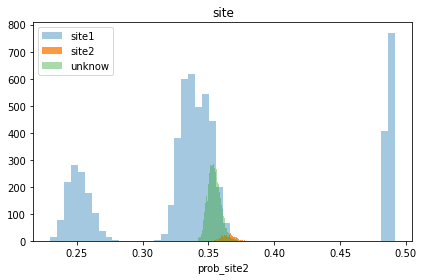

In [21]:
plt.hist(_all_val_df["prob_site2"].values, label="site1", bins=50, alpha=0.4)
plt.hist(all_test_df[all_test_df["is_site2_true"]==1]["prob_site2"].values, label="site2", bins=50, alpha=0.8)
plt.hist(all_test_df[all_test_df["is_site2_true"]=="unknow"]["prob_site2"].values, label="unknow", bins=50, alpha=0.4)
plt.legend()
plt.title("site")
plt.xlabel("prob_site2")
plt.tight_layout()
plt.savefig("adversal/distribution_of_df_icapca.png")

In [39]:
describe = all_test_df.groupby("is_site2_true").describe()["prob_site2"]
std = describe["std"].values[0]
mean = describe["50%"].values[0]
print(std, mean)
describe

0.004757923173416897 0.3651777575915719


,count,mean,std,min,25%,50%,75%,max
is_site2_true,,,,,,,,
1.0,510.0,0.365008,0.004758,0.352612,0.361576,0.365178,0.368173,0.379099
unknow,5367.0,0.354356,0.004802,0.341790,0.350956,0.354027,0.357475,0.373549


In [40]:
sigma_2 = mean - 2*std  # 2σなので、分布的には全体のデータの95%の確率でsite2が含まれる
print(sigma_2)

_all_val_df["is_site2"] = _all_val_df["prob_site2"].values > sigma_2
all_test_df["is_site2"] = all_test_df["prob_site2"].values > sigma_2

_all_val_df.to_csv('adversal/train_prob_site2_icapca.csv', index=False)
all_test_df.to_csv('adversal/test_prob_site2_icapca.csv', index=False)



0.3556619112447381


In [41]:
all_test_df.is_site2.sum()

2515

In [42]:
_all_val_df.is_site2.sum()

1462